In [1]:
import collections
import copy

import equilibrator_api
import ipywidgets as widgets
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML, JSON, SVG, display

from mosmo.knowledge import kb
from mosmo.model import DS, KbEntry, DbXref, Molecule, Reaction, Pathway
from mosmo.preso.escher import escher_map

KB = kb.configure_kb()

def mode_formula(pw, mode):
    parts = []
    for reaction, coeff in zip(pw.reactions.labels(), mode):
        if coeff == -1:
            parts.append('-')
        elif coeff < 0:
            parts.append(f'- {-coeff}')
        elif coeff == 1:
            if parts:
                parts.append('+')
        elif coeff > 0:
            if parts:
                parts.append(f'+ {coeff}')
            else:
                parts.append(f'{coeff}')
        
        if coeff:
            parts.append(reaction)
    
    return ' '.join(parts)

cc = equilibrator_api.ComponentContribution()
Q_ = equilibrator_api.Q_
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

def find_cc_met(met):
    if met.xrefs:
        for xref in met.xrefs:
            if xref.db == DS.KEGG:
                return cc.get_compound(f'KEGG:{xref.id}')
    return None


In [2]:
glycolysis = KB('glycolysis')
glycolysis_plus = KB('glycolysis_ppp_ov')
tca = KB('tca_cycle')
central_carbon = KB('central_carbon')

## Compare reaction $\Delta{G}^{\circ}_r$ values to eQuilibrator site

In [3]:
cc.p_h = Q_(7.3)
cc.p_mg = Q_(1.5)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")

for reaction in glycolysis.reactions:
    cc_mets = {}
    for met, count in reaction.stoichiometry.items():
        cc_met = find_cc_met(met)
        cc_mets[met] = (cc_met, count)
    
    cc_rxn = equilibrator_api.Reaction({k: v for k, v in cc_mets.values()})
    
    print(f'[{reaction.id}] {reaction.name}')
    print(f'ΔG = {cc.standard_dg_prime(cc_rxn)}')
    for met, (cc_met, count) in cc_mets.items():
        print(f'    {count:+2d} {(cc.standard_dg_formation(cc_met)[0] or 0.0):8.2f} [{cc_met.id:6d}] [{met.id}] {met.name}')
    print()

[pgi] Glucose-6-phosphate Isomerase
ΔG = (-0.0 +/- 0.4) kilojoule / mole
    -1 -1763.82 [   152] [Glc.D.6P] D-glucose 6-phosphate
    +1 -1760.88 [125172] [Fru.D.6P] D-fructose 6-phosphate

[pfk] 6-phosphofructokinase
ΔG = (-16.2 +/- 0.7) kilojoule / mole
    -1 -2811.58 [     6] [atp] adenosine triphosphate
    -1 -1760.88 [125172] [Fru.D.6P] D-fructose 6-phosphate
    +1 -1945.43 [    10] [adp] adenosine diphosphate
    +1 -2598.86 [   396] [Fru.D.bis16] D-fructose 1,6-bisphosphate
    +1     0.00 [     4] [h+] proton

[fbp] Fuctose-bisphosphatase
ΔG = (-14.0 +/- 0.7) kilojoule / mole
    -1 -2598.86 [   396] [Fru.D.bis16] D-fructose 1,6-bisphosphate
    -1  -238.14 [     5] [h2o] water
    +1 -1760.88 [125172] [Fru.D.6P] D-fructose 6-phosphate
    +1 -1095.21 [    12] [pi] phosphate

[fba] Fructose-bisphosphate Aldolase
ΔG = (28.1 +/- 0.5) kilojoule / mole
    -1 -2598.86 [   396] [Fru.D.bis16] D-fructose 1,6-bisphosphate
    +1 -1289.12 [    71] [gap] D-glyceraldehyde 3-phosphate


### TBD
- CO2 vs CO2[tot], i.e. CO2 + HCO3- etc
  - Could just add the reaction CO2 + H2O <=> CO2[tot]

## State-dependent $\Delta{G} = \Delta{G^{\circ}} + R T ln{Q}$

In [4]:
# All taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4912430/, except where starred
POOLS = {KB(met_id): conc for met_id, conc in [
    ('2pg', 9.18e-02),
    ('3pg', 1.54),
    ('6pg', 3.77),
    ('6pgdl', 1.), # ************
    ('Ery.D.4P', 4.90e-02),
    ('Fru.D.6P', 2.52),
    ('Fru.D.bis16', 15.2),
    ('Glc.D.6P', 7.88),
    ('Rib.D.5P', 7.87e-01),
    ('Rul.D.5P', 1.12e-01),
    ('Sed.D.7P', 8.82e-01),
    ('Xul.D.5P', 1.81e-01),
    ('accoa', 6.06e-01),
    ('acon', 1.61e-02),
    ('adp', 5.55e-01),
    ('akg', 4.43e-01),
    ('amp', 2.81e-01),
    ('atp', 9.63),
    ('cit', 1.96),
    ('co2', 7.52e-02),
    ('coa', 1.37),
    ('dhap', 3.06),
    ('dpg', 1.65e-02),
    ('fum', 2.88e-01),
    ('gap', 2.71e-01),
    ('glx', 0.1),  # **********

    # Exclude water and protons from ΔG calculations (justification??)
    # ('h+', 1e-7),
    # ('h2o', 55500),

    ('icit', 3.67e-02),
    ('kdpg', 0.01),  # **********
    ('mal.L', 1.68),
    ('nad.ox', 2.55),
    ('nad.red', 8.36e-02),
    ('nadp.ox', 2.08e-03),
    ('nadp.red', 1.21e-01),
    ('oaa', 4.87e-04),
    ('pep', 1.84e-01),
    ('pi', 23.9),
    ('pyr', 3.66),
    ('q.ox', 0.01),  # **********
    ('q.red', 0.01),  # **********
    ('succ', 5.69e-01),
    ('succcoa', 2.33e-01),
]}


In [5]:
glyco_mode = [
    (KB('pgi'), 1),
    (KB('pfk'), 1),
    (KB('fba'), 1),
    (KB('tpi'), -1),
    (KB('gapdh'), 2),
    (KB('pgk'), -2),
    (KB('gpm'), -2),
    (KB('eno'), 2),
]

net_rxn = sum(rxn * factor for rxn, factor in glyco_mode)
net_rxn.data()

1*pgi+1*pfk+1*fba+-1*tpi+2*gapdh+-2*pgk+-2*gpm+2*eno
name: None
shorthand: None
aka: None
description: None
xrefs: None
equation: 
    G6P + ADP + 2 NAD+ + 2 Pi <=> ATP + 3 H+ + 2 NADH + 2
    H2O + 2 PEP
reversible: True
catalyst: None


In [6]:
def calculate_dg(reaction, concs):
    cc_stoich = {}
    rxn_q = 1.0
    for met, count in reaction.stoichiometry.items():
        cc_stoich[find_cc_met(met)] = count
        if met in concs:
            # Concentrations are in mM, but ΔG is standardized on M
            rxn_q = rxn_q * (concs[met] * 1e-3)**count

    cc_rxn = equilibrator_api.Reaction(cc_stoich)
    dg0 = cc.standard_dg_prime(cc_rxn)
    dg = dg0 + cc.RT * np.log(rxn_q)
    return dg0, dg

coeffs = []
dg0s = []
dgs = []
for reaction, coeff in glyco_mode:
    coeffs.append(coeff)
    dg0, dg = calculate_dg(reaction, POOLS)
    # TODO: figure out pint (units) and uncertainties. For now, jump straight to the value
    dg0s.append(dg0.magnitude.nominal_value)
    dgs.append(dg.magnitude.nominal_value)

coeffs = np.array(coeffs)
dg0s = np.array(dg0s)
dgs = np.array(dgs)

**TODO**: figure out [pint](https://pint.readthedocs.io/en/stable/) (_i.e._ units) and [uncertainties](https://pythonhosted.org/uncertainties/) packages

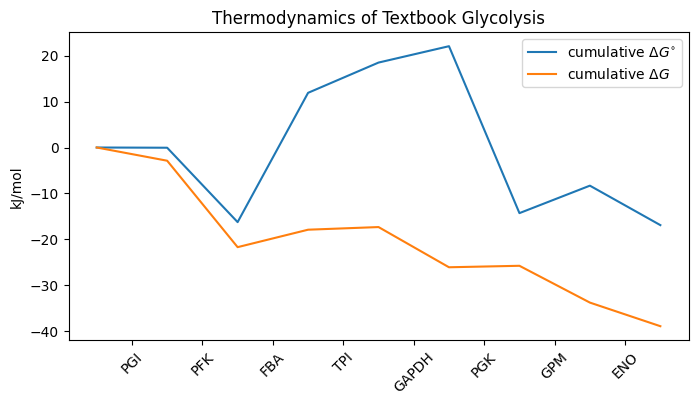

In [7]:
path0 = np.insert(np.cumsum(dg0s * coeffs), 0, 0)
path = np.insert(np.cumsum(dgs * coeffs), 0, 0)

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(path0, label='cumulative $\Delta{G}^{\circ}$')
ax.plot(path, label='cumulative $\Delta{G}$')
ax.set_xticks(np.arange(len(glyco_mode)) + 0.5, (rxn.label for rxn, coeff in glyco_mode), rotation=45)
ax.set_title('Thermodynamics of Textbook Glycolysis')
ax.set_ylabel('kJ/mol')
ax.legend()
plt.show()

- In isolation, FBA looks irreversible in the wrong direction, and PGK in the right one.
- But considering metabolite concentrations, each is pretty close to equilibrium
- Overall path is substantially downhill _under these conditions_


# Systematic Calculations (Glycolysis + PPP)

In [8]:
std_dg_r = {}
for rxn in central_carbon.reactions:
    cc_rxn = equilibrator_api.Reaction({find_cc_met(met): count for met, count in rxn.stoichiometry.items()})
    std_dg_r[rxn] = cc.standard_dg_prime(cc_rxn)

### Using matrix math:

$\Delta{G}_r = \Delta{G}_r^\circ + RT \cdot ln{(\frac{\prod{c_p}}{\prod{c_s}})}$

$ = \Delta{G}_r^\circ + RT \cdot (ln(\prod{c_p})- ln(\prod{c_s}))$

$ = \Delta{G}_r^\circ + RT \cdot \sum\limits_i{S_{i,r} ln (c_i)}$

$\vec{\Delta{G}_r} = \vec{\Delta{G}^\circ} + RT \cdot (\mathbf{S} \cdot ln (\vec{c}))$


### Work with Glycolysis + PPP, from G6P to pyruvate

In [9]:
glycolysis_plus.data()

CANON:glycolysis_ppp_ov
name: Glycolysis + PPP + Overflow
shorthand: None
aka: None
description: None
xrefs: None
size: 26 reactions over 35 molecules.
reactions: 
    [pts.glc] Glc[e] + PEP => G6P + pyr
    [pgi] G6P <=> F6P
    [pfk] ATP + F6P => ADP + FDP + H+
    [fbp] FDP + H2O => F6P + Pi
    [fba] FDP <=> GAP + DHAP
    [tpi] GAP <=> DHAP
    [gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH
    [pgk] 3PG + ATP <=> DPG + ADP
    [gpm] 2PG <=> 3PG
    [eno] 2PG <=> H2O + PEP
    [pyk] ATP + pyr <=> ADP + H+ + PEP
    [pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+
    [pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH
    [pta] acCoA + Pi <=> acP + CoA
    [ack] ac + ATP <=> acP + ADP
    [aclig] ac + ATP + CoA <=> acCoA + AMP + PPi
    [g6pdh] G6P + NADP+ <=> 6PGDL + H+ + NADPH
    [pglase] 6PGDL + H2O => 6PG + H+
    [pgldh] 6PG + NADP+ => CO2 + Ru5P + NADPH
    [r5pi] R5P <=> Ru5P
    [rpe] Ru5P <=> Xu5P
    [tkt.c5c5] GAP + Sed7P <=> R5P + Xu5P
    [tkt.c5c4] E4P + Xu5P <=> F6P + GAP
    

In [10]:
pw = Pathway(
    id='pw',
    reactions=[
        r for r in glycolysis_plus.reactions 
        if r.id not in ('pyk', 'pps', 'pdh', 'pta', 'ack', 'aclig', 'pts.glc', 'pgldhat', 'kdpga')
    ],
    diagram=glycolysis_plus.diagram)
pw.data()
print()

dg0 = np.array([std_dg_r[rxn].magnitude.nominal_value for rxn in pw.reactions])
ln_conc = np.log(np.array([POOLS.get(met, 1e3) * 1e-3 for met in pw.molecules]))
dg = dg0 + cc.RT.magnitude * pw.s_matrix.T @ ln_conc

pd.Series(dg, index=pw.reactions.labels())

pw
name: None
shorthand: None
aka: None
description: None
xrefs: None
size: 17 reactions over 26 molecules.
reactions: 
    [pgi] G6P <=> F6P
    [pfk] ATP + F6P => ADP + FDP + H+
    [fbp] FDP + H2O => F6P + Pi
    [fba] FDP <=> GAP + DHAP
    [tpi] GAP <=> DHAP
    [gapdh] GAP + NAD+ + Pi <=> DPG + H+ + NADH
    [pgk] 3PG + ATP <=> DPG + ADP
    [gpm] 2PG <=> 3PG
    [eno] 2PG <=> H2O + PEP
    [g6pdh] G6P + NADP+ <=> 6PGDL + H+ + NADPH
    [pglase] 6PGDL + H2O => 6PG + H+
    [pgldh] 6PG + NADP+ => CO2 + Ru5P + NADPH
    [r5pi] R5P <=> Ru5P
    [rpe] Ru5P <=> Xu5P
    [tkt.c5c5] GAP + Sed7P <=> R5P + Xu5P
    [tkt.c5c4] E4P + Xu5P <=> F6P + GAP
    [tal] GAP + Sed7P <=> F6P + E4P



PGI       -2.874524
PFK      -18.795882
FBP      -27.654230
FBA        3.795067
TPI       -0.574578
GAPDH     -4.371253
PGK       -0.159990
GPM        4.000982
ENO       -2.567201
G6PDH     -0.952827
PGLase   -22.528238
PGLDH    -11.504466
RPI       -1.633633
RPE       -2.273729
TKT1       1.166628
TKT2      -3.183528
TALA      -6.467252
dtype: float64

## Thermodynamics of Elementary Modes

#### Elementary Modes code, mostly now migrated to mosmo.calc.elementary_modes

In [11]:
def build_internal_system(pw, bounds):
    """Returns S matrix with rows for internal (non-bounds) metabolites only."""
    intermediates = [met not in bounds for met in pw.molecules]
    return pw.s_matrix[intermediates].astype(int)

def sort_tableau(tableau, j):
    # Existing modes that already satisfy steady state j will be part of the next tableau. 
    # Others will either be merged or dropped.
    elementary = []
    pending = []
    for mode, reversible, zeros in tableau:
        if mode[j] == 0:
            elementary.append((mode, reversible, zeros))
        else:
            pending.append((mode, reversible, zeros))
    return elementary, pending

def generate_candidates(pending, j):
    # All pending mode pairs are merge candidates, unless they violate irreversibility.
    candidates = []
    for i, (mode_i, reversible_i, zeros_i) in enumerate(pending):
        for mode_m, reversible_m, zeros_m in pending[i+1:]:
            # Put a reversible mode second if possible, so we can always multiply the first by a positive number
            if reversible_m:
                candidates.append((mode_i, mode_m, reversible_i and reversible_m, zeros_i & zeros_m))
            elif reversible_i:
                candidates.append((mode_m, mode_i, reversible_i and reversible_m, zeros_i & zeros_m))

            # Otherwise we can still combine them, if they have opposite stoichiometry
            elif mode_i[j] * mode_m[j] < 0:
                candidates.append((mode_i, mode_m, False, zeros_i & zeros_m))
    return candidates

def merge_modes(mode_i, mode_m, reversible, j, num_rxns):
    # All integer arithmetic. We want integer scaling in simplest form.
    multiple = int(np.lcm(mode_i[j], mode_m[j]))
    # scale_i is always positive
    scale_i = int(multiple / abs(mode_i[j]))
    # scale_m satisfies scale_i * mode_i[j] + scale_m * mode_m[j] = 0. 
    scale_m = -int(scale_i * mode_i[j] / mode_m[j])

    # Combine modes, and reduce to simplest integers.
    mode = scale_i * mode_i + scale_m * mode_m
    mode = (mode / np.gcd.reduce(mode)).astype(int)
    
    # Determine the actual new zeros set on the moerged mode.
    zeros = set(np.nonzero(mode[-num_rxns:] == 0)[0])
    
    # Mostly esthetic, but prefer original reaction direction for reversible modes
    if reversible:
        involved = num_rxns - len(zeros)
        forward = np.nonzero(mode[-num_rxns:] > 0)[0].shape[0]
        if forward * 2 < involved:
            mode = -mode

    return mode, reversible, zeros

def process_candidates(candidates, modes, j, num_rxns):
    # Compare candidates against all other elementary modes, based on the non-subset zeros test.
    for i, (mode_i, mode_m, reversible, zeros) in enumerate(candidates):
        passing = True
        for _, _, other_zeros in modes:
            if zeros <= other_zeros:  # subset or equal
                # print(f'  {mode_i} + {mode_m} Fails because {zeros} <= {other_zeros}')
                passing = False
                break

        # If the candidate survived, keep it. Other candidates must now compare against this new mode too.
        if passing:
            modes.append(merge_modes(mode_i, mode_m, reversible, j, num_rxns))
    
    return modes

# def elementary_modes(pw, bounds):
def elementary_modes(s_matrix, reversibilities):
    # tableau = init_tableau(pw, bounds)
    num_mets, num_rxns = s_matrix.shape
    modes = list(np.concatenate([s_matrix, np.eye(num_rxns, dtype=int)]).T)
    tableau = [(mode, reversible, set(np.nonzero(mode[-num_rxns:] == 0)[0]))
                for mode, reversible in zip(modes, reversibilities)]

    for j in range(num_mets):
        modes, pending = sort_tableau(tableau, j)
        candidates = generate_candidates(pending, j)
        # TODO: optimization based on cardinality of merged zeros set, per Urbanczik & Wagner (2004)?
        
        tableau = process_candidates(candidates, modes, j, num_rxns)
        
    modes = []
    rev = []
    for mode, reversible, zeros in tableau:
        modes.append(mode[-num_rxns:])
        rev.append(reversible)
    
    return np.array(modes, dtype=int).T, rev


def show_modes(pw, modes, rev):
    s_elementary = (pw.s_matrix.astype(int) @ modes)
    net_reactions = []
    for i, (mode, reversible) in enumerate(zip(s_elementary.T, rev)):
        stoich = {}
        for met, count in zip(pw.molecules, mode):
            if count != 0:
                stoich[met] = count

        net_reaction = Reaction(id=f'mode{i}', name=f'Elementary Mode {i}', stoichiometry=stoich, reversible=reversible)
        net_reactions.append(net_reaction)

    w = f'{160 + modes.shape[1] * 8:d}px' if modes.shape[1] < 80 else '100%'
    mode_select = widgets.IntSlider(
        value=0,
        min=0,
        max=modes.shape[1] - 1,
        description='Mode',
        continuous_update=True,
        readout=True,
        layout={'width': w}
    )
    mode_fluxes = widgets.Text(description='flux ratios', layout={'width': '100%'})
    mode_net = widgets.Text(description='net reaction', layout={'width': '100%'})
    diag = escher_map.EscherMap(
        pw.diagram,
        height="600px",
        reaction_scale=escher_map.Scale({0.: ("#eeeeee", 3), 6.: ("#1f77cc", 50)}, use_abs=True))
    diag_canvas = widgets.Output()

    def show_mode(change):
        mode = mode_select.value
        mode_fluxes.value = mode_formula(pw, modes.T[mode])
        mode_net.value = net_reactions[mode].equation
        diag_canvas.clear_output(wait=True)
        with diag_canvas:
            display(SVG(
                diag.draw(
                    reaction_data={r.id: v for r, v in zip(pw.reactions, modes.T[mode])}
                )
            ))

    mode_select.observe(show_mode, names='value')
    show_mode(None)

    return widgets.VBox([
        mode_select,
        mode_fluxes,
        mode_net,
        diag_canvas,
    ], layout={"width": "1000px", "border": "1px solid green"})

In [12]:
bounds = {KB.get(KB.compounds, met_id) for met_id in [
    'Glc.D.6P',
    'Rib.D.5P',
    'pep',
    'co2',
    'amp',
    'adp',
    'atp',
    'nad.ox',
    'nad.red',
    'nadp.ox',
    'nadp.red',
    'pi',
    'h2o',
    'h+',
]}

modes, rev = elementary_modes(build_internal_system(pw, bounds), [rxn.reversible for rxn in pw.reactions])
pd.DataFrame(modes, index=pw.reactions.labels())

,0,1,2,3,4,5,6,7,8,9,10,11
PGI,0,1,-1,0,-2,5,-5,-2,-5,0,0,0
PFK,1,1,0,0,0,1,0,0,0,2,2,0
FBP,1,0,1,0,0,0,1,0,1,0,0,2
FBA,0,1,-1,0,0,1,-1,0,-1,2,2,-2
TPI,0,-1,1,0,0,-1,1,0,1,-2,-2,2
GAPDH,0,2,-2,0,1,0,0,1,0,5,5,-5
PGK,0,-2,2,0,-1,0,0,-1,0,-5,-5,5
GPM,0,-2,2,0,-1,0,0,-1,0,-5,-5,5
ENO,0,2,-2,0,1,0,0,1,0,5,5,-5
G6PDH,0,0,0,1,0,0,0,2,4,0,2,0


In [13]:
show_modes(pw, modes, rev)

$\Delta{G}_m = \sum\limits_r {m_r \Delta{G}_r}$

$\vec{\Delta{G}_m} = \mathbf{M^T} \cdot \vec{\Delta{G}}_r$

In [14]:
modes.T @ dg

array([ -46.45011234,  -38.85965562,   -7.59045672,  -33.35189808,
        -23.66252952,    8.46540343,  -54.91551577,  -90.36632569,
       -188.3231081 , -101.38184076, -168.08563693,    8.48161608])

# Elementary Modes of TCA (+ anaplerosis)

CANON:tca_cycle
name: TCA cycle
shorthand: None
aka: None
description: None
xrefs: None
size: 17 reactions over 26 molecules.
reactions: 
    [citsyn] acCoA + H2O + OAA <=> cit + CoA + H+
    [acnh] cit <=> icit
    [icd] icit + NADP+ <=> αkg + CO2 + NADPH
    [akgdh] αkg + CoA + NAD+ <=> CO2 + NADH + succCoA
    [succoasyn] ATP + CoA + succ <=> ADP + Pi + succCoA
    [sdh] Q + succ <=> QH2 + fum
    [fumhyd] mal <=> fum + H2O
    [mdh] mal + NAD+ <=> H+ + NADH + OAA
    [iclase] icit <=> glx + succ
    [msase] acCoA + glx + H2O <=> mal + CoA + H+
    [ppc] H+ + OAA + Pi <=> CO2 + H2O + PEP
    [ppck] ATP + OAA => ADP + CO2 + PEP
    [mae.nad] mal + NAD+ => CO2 + NADH + pyr
    [mae.nadp] mal + NADP+ => CO2 + NADPH + pyr
    [pyk] ATP + pyr <=> ADP + H+ + PEP
    [pps] ATP + H2O + pyr => AMP + Pi + PEP + 2 H+
    [pdh] CoA + NAD+ + pyr => acCoA + CO2 + NADH


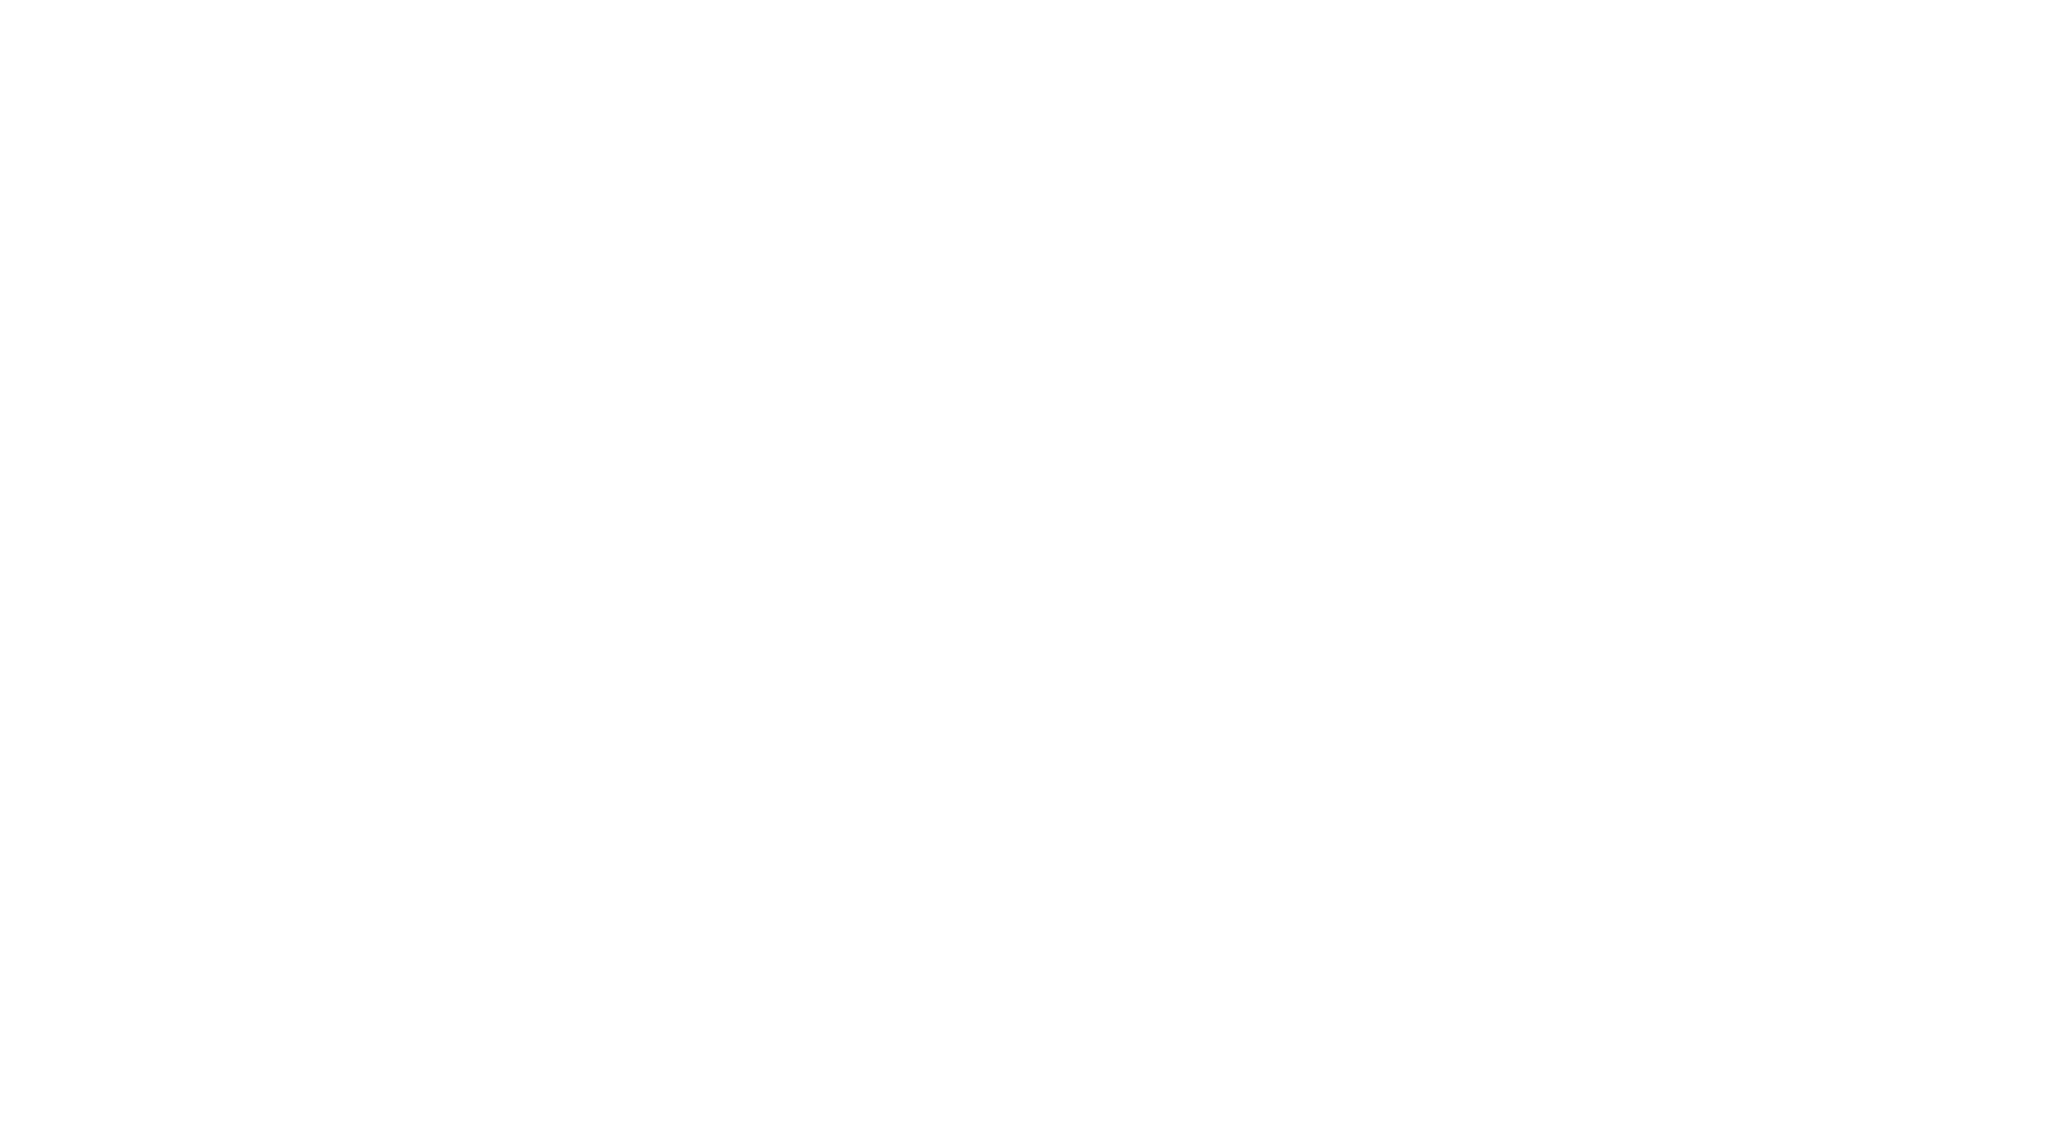

In [15]:
pw = tca
pw.data()
diag = escher_map.EscherMap(
    pw.diagram, width="10in",
    reaction_scale=escher_map.Scale({0.: ("#eeeeee", 3), 1.: ("#1f77cc", 20)}, use_abs=True))
SVG(diag.draw(reaction_data={r.id: 1 for r in pw.reactions}))

In [16]:
boundaries = {
    KB('pep'), KB('pyr'), KB('accoa'), KB('oaa'), KB('akg'),
    KB('amp'), KB('adp'), KB('atp'), KB('pi'),
    KB('nad.ox'), KB('nad.red'), KB('nadp.ox'), KB('nadp.red'), KB('q.ox'), KB('q.red'),    
    KB('coa'),    
    KB('h+'), KB('h2o'), KB('co2')
}
# Possibly treat a subset of the boundaries as exchanges
exchanges = {
    KB('pep'): 0,
    KB('pyr'): 0,
    KB('accoa'): -1,
    KB('oaa'): -1,
    KB('akg'): -1,
}

def augmented_internal_system(pw, bounds, exchanges):
    """Returns S matrix with rows for internal and exchanged metabolites only."""
    
    # Append columns ('reactions') with a single entry for each exchange
    exchange_cols = np.zeros((pw.shape[0], len(exchanges)), dtype=int)
    for j, (met, direction) in enumerate(exchanges.items()):
        exchange_cols[pw.molecules.index_of(met), j] = direction or 1

    intermediates = [met not in bounds for met in pw.molecules]
    s_matrix = np.concatenate([pw.s_matrix.astype(int), exchange_cols], axis=1)
    reversibility = [reaction.reversible for reaction in pw.reactions]
    reversibility.extend(direction == 0 for met, direction in exchanges.items())
    return s_matrix[intermediates],  reversibility

internal_system, reversibility = augmented_internal_system(pw, boundaries - exchanges.keys(), exchanges)
print(internal_system.shape, len(reversibility))
modes, mrev = elementary_modes(internal_system, reversibility)
modes = modes[:pw.shape[1]]
print(f'{modes.shape[1]} elementary modes')

show_modes(pw, modes, mrev)

(12, 22) 22
113 elementary modes


## Use current $\Delta{G}_r$ to constrain reaction direction 

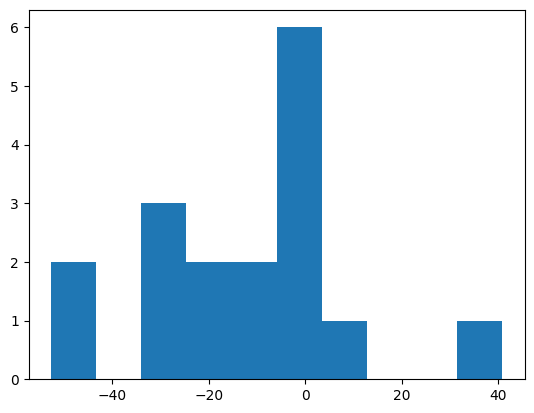

CS      -17.524282
ACN       3.252262
ICD      -3.372707
AKGDH   -48.229917
SCS      -9.620471
SDH     -25.277125
FUM      -0.903246
MDH      -0.372701
ICL      -6.727101
MALS    -25.828589
PPC      40.831996
PPCK     -5.618116
MAE-A   -18.746605
MAE-B    -3.189822
PYK      12.755788
PPS     -26.237576
PDH     -52.686754
dtype: float64

In [17]:
dg0 = np.array([std_dg_r[rxn].magnitude.nominal_value for rxn in pw.reactions])
ln_conc = np.log(np.array([POOLS.get(met, 1e3) * 1e-3 for met in pw.molecules]))
dg = dg0 + cc.RT.magnitude * pw.s_matrix.T @ ln_conc

plt.hist(dg)
plt.show()

pd.Series(dg, index=pw.reactions.labels())

### Strategy:
- Use a vector of +1 & -1 to set thermodynamic direction of each reaction
    - Operates directly on the S matrix, leaves `pw` unchanged, requires no changes to Reaction objects
- Reversibility based on |ΔG| < threshold, _overriding_ any preset reversibility on the Reaction.
    - Strictly speaking, threshold should be 0, but positive threshold allows for uncertainty in ΔG° and/or Q
    - Eventually, use uncertainty directly instead of a threshold parameter?

In [18]:
print(dg)

direction = (-dg / np.abs(dg)).astype(int)
print(direction)

threshold = 5.0
reversibility = np.abs(dg) < threshold
print(reversibility)


[-17.52428208   3.25226181  -3.37270737 -48.22991716  -9.62047124
 -25.27712524  -0.90324612  -0.37270092  -6.72710142 -25.82858881
  40.83199611  -5.61811623 -18.74660526  -3.18982175  12.75578811
 -26.23757572 -52.68675364]
[ 1 -1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1]
[False  True  True False False False  True  True False False False False
 False  True False False False]


In [19]:
# Interaction between augmented system and thermo-reversibility. Need to clean this up in the final API, but just muddle through for now

threshold = 5.0
internal_system, raw_rev = augmented_internal_system(pw, boundaries - exchanges.keys(), exchanges)
augments = len(exchanges)
direction = np.append(-dg / np.abs(dg), np.ones(augments)).astype(int)
reversibility = np.append(np.abs(dg) < threshold, raw_rev[-augments:])
print(internal_system.shape, direction.shape, reversibility.shape)

modes, mrev = elementary_modes(internal_system * direction, reversibility)
modes = (modes.T * direction).T[:pw.shape[1]]
print(f'{modes.shape[1]} elementary modes')

show_modes(pw, modes, mrev)

(12, 22) (22,) (22,)
41 elementary modes


Interesting. Not one of the thermodynamic modes includes the textbook TCA cycle.
- The culprit is Succinyl CoA synthetase, which is thermodynamically irreversible in the wrong direction to allow cyclic flux
    - If I set the threshold >= 9.7 the cycle appears as a mode. But that's a pretty big miss.
- Is the reported concentration of succCoA too low? Or does biosynthesis consume enough succCoA to keep it low (and disallow the cycle)?